In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import inchi
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import matthews_corrcoef,accuracy_score,precision_score,confusion_matrix, f1_score,recall_score,balanced_accuracy_score, roc_curve,roc_auc_score

In [2]:
df = pd.read_csv("external validation.csv")
df.head()

df_train = pd.read_csv("train_validation_cardio_tox_data_clean.csv")
df_train = df_train[['smiles','activity']]
df_train

,smiles,activity
0,Fc1ccc(-n2cc(NCCN3CCCCC3)nn2)cc1F,1
1,COc1cc(N2Cc3ccc(Sc4ccc(F)cc4)nc3C2=O)ccc1OCCN1...,0
2,CCOC(=O)[C@H]1CC[C@@H](N2CC(NC(=O)CNc3nn(C(N)=...,0
3,N[C@@H](Cn1c(=O)cnc2ccc(F)cc21)C1CCC(NCc2ccc3c...,0
4,O=C(NC1COc2cccc(-c3ccnc(CO)c3)c2C1)c1ccc(OCC(F...,0
...,...,...
12615,Cc1cc(-c2ccc3c(c2)CCN(CCCSc2nnc(-c4ccc5nc(C)c(...,1
12616,CCCn1c(=O)c2[nH]c(-c3cnn(CC#Cc4cccc(OC(F)(F)F)...,0
12617,Cc1cc2ncc(C(=O)NCC(C)(C)NCC(=O)N3CCC[C@H]3C#N)...,0
12618,O=C(NC[C@@H](O)CN1CCC(Oc2ccc(Cl)c(Cl)c2)CC1)c1...,1


In [3]:
from rdkit import Chem

# Assuming your dataset is stored in a DataFrame called 'smiles_df'
# And the SMILES are in the 'smiles' column

# Add a new column for InChIKey
df['inchikey'] = df['smiles'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromSmiles(x)) if Chem.MolFromSmiles(x) is not None else None)
df_train['inchikey']= df_train['smiles'].apply(lambda x: Chem.MolToInchiKey(Chem.MolFromSmiles(x)) if Chem.MolFromSmiles(x) is not None else None)

# Rename the 'labels' column to 'activity'
df.rename(columns={'labels': 'activity'}, inplace=True)

# Create a new DataFrame with random 850 data
#random_850_df = smiles_df.sample(n=850, random_state=42)

# Display the first few rows of the new DataFrame
#print(random_850_df.head())

df.info()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10355 entries, 0 to 10354
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   smiles    10355 non-null  object
 1   activity  10355 non-null  int64 
 2   inchikey  10355 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12620 entries, 0 to 12619
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   smiles    12620 non-null  object
 1   activity  12620 non-null  int64 
 2   inchikey  12620 non-null  object
dtypes: int64(1), object(2)
memory usage: 295.9+ KB


In [4]:
common_inchikey = df["inchikey"].isin(df_train["inchikey"])
common_inchikey_count = common_inchikey.sum()

print("The number of molecules from external datasets present in training datasets is:", common_inchikey_count)

The number of molecules from external datasets present in training datasets is: 7740


In [5]:
# Filter out rows with common inchikey values
df_filtered = df[~common_inchikey]
df_filtered
# Display the filtered DataFrame
#print(df_filtered)


,smiles,activity,inchikey
4,O=C(Cn1ccc2ncc(-c3ccc(F)c(C(F)F)c3)cc21)N1CCC1,1,PHEQYRFWXXPUFW-UHFFFAOYSA-N
8,CNCc1cc(C(=O)N[C@@H]2CCc3ccc(Oc4ccnc5c4CCC(=O)...,1,CHOXZXLXXUVMGG-OAQYLSRUSA-N
9,COc1cc(C(O)(CCn2ccnc2)C(c2cc3cc(Br)ccc3nc2OC)c...,1,IKSKNYJMDKYTOW-UHFFFAOYSA-N
13,CC(C)c1cc(COc2ccccc2CC(=O)O)cc(-c2ccc3c(c2)[C@...,0,WQVBAYOMZJYFJK-HSZRJFAPSA-N
17,CCOC(=O)N1CC/C(=C\C#Cc2cccc(C)n2)C1,0,NDVDBJIRXMBDOD-VGOFMYFVSA-N
...,...,...,...
10335,CC(C)OC(=O)N1CCC(C)(CN2CCC3(CC2)CN(S(C)(=O)=O)...,1,GKQPPHRQSZDMNP-UHFFFAOYSA-N
10336,Cn1cc(-c2ccc(O[C@@H]3CCN(C(=O)Cc4ccc(OC(F)(F)F...,1,DEGILXGFBNYPQN-QGZVFWFLSA-N
10339,N#Cc1ccc(CNC(=O)N(c2cccc(F)c2)C2CCN(CCC3(c4ccc...,1,ADKFAXSAYOKAIZ-UHFFFAOYSA-N
10346,O=C(NC1CCN(Cc2ccc3c(c2)OCO3)CC1)c1cc(=O)c2ccc(...,1,PPJGRQFHPGWXNI-UHFFFAOYSA-N


In [7]:
# Create a new DataFrame with random 870 data to validate the model
valid_df = df_filtered.sample(n=870, random_state=42)
valid_df

# Save valid_df to a CSV file
valid_df.to_csv('valid_data.csv', index=False)


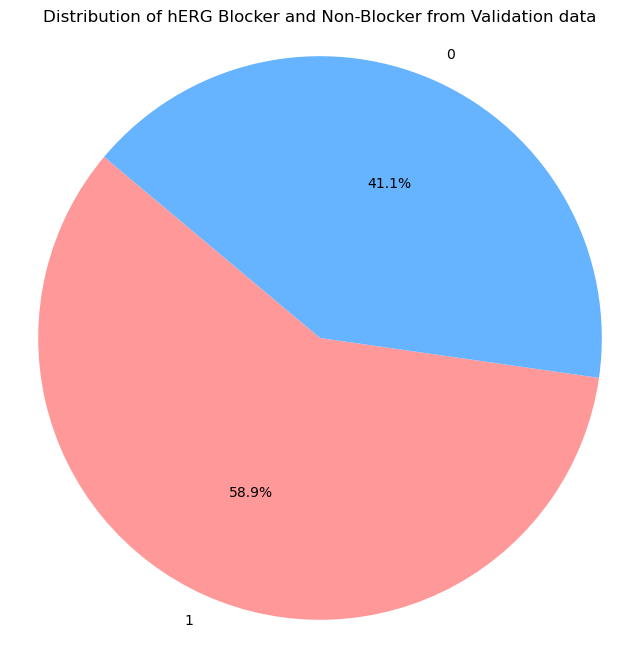

In [8]:
import matplotlib.pyplot as plt

# Map the values in the 'activity' column to 'herg blocker' and 'herg non-blocker'
valid_df['activity'] = valid_df['activity']

# Calculate the counts of 'herg blocker' and 'herg non-blocker'
counts = valid_df['activity'].value_counts()

# Define colors for 'herg blocker' and 'herg non-blocker'
colors = ['#ff9999', '#66b3ff']

# Plot a 2D pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of hERG Blocker and Non-Blocker from Validation data')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


From this pie, 0 denote 'hERG non-blocker', while 1 denote 'hERG blocker'. The dataset used in validating the model has 
molecules about 58.9% that are blockers

In [ ]:
#reading the prediction output that was run on ersilia
prediction_df = pd.read_csv('predicted_values.csv')
prediction_df.head()

In [10]:
#set a threshold value to 0.5 
#convert the probability column to a binary prediction
predicted_output = (prediction_df['probability'] >= 0.5).astype(int)

# Extract the ACTIVITY column of the validation dataset
test_output = valid_df['activity'] 

In [11]:
# Calculate Matthews correlation coefficient
mcc = matthews_corrcoef(test_output, predicted_output)

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_output, predicted_output)

# Calculate NPV
tn, fp, fn, tp = conf_matrix.ravel()
npv = tn / (tn + fn)

# Calculate accuracy
accuracy = accuracy_score(test_output, predicted_output)

# Calculate precision 
precision = precision_score(test_output, predicted_output)#represent PPV

# Calculate SPE
spe = tn / (tn + fp)

# Calculate recall
recall = recall_score(test_output, predicted_output)

# Calculate F1 score
f1 = f1_score(test_output, predicted_output)

# Calculate balanced accuracy
balanced_accuracy = balanced_accuracy_score(test_output, predicted_output)


In [12]:
print("RESULTS:")

# Print the results with three decimal places
print(f"MCC: {mcc:.3f}")
print(f"NPV: {npv:.3f}")
print(f"ACC: {accuracy:.3f}")
print(f"PPV: {precision:.3f}")
print(f"SPE: {spe:.3f}")
print(f"SEN: {recall:.3f}")
print(f"B-ACC: {balanced_accuracy:.3f}")

RESULTS:
MCC: 0.326
NPV: 0.573
ACC: 0.661
PPV: 0.748
SPE: 0.693
SEN: 0.639
B-ACC: 0.666


The PPV & NPV metrics indicating better performance in certain aspects of classification while the remaining evaluation metrics suggest moderate performance. From this evaluation metrics, it shows that the model performed moderately well and have the predicting ability to identify hERG blocker.


In [13]:
prediction_df['probability']

0      0.315886
1      0.572158
2      0.324096
3      0.916053
4      0.923717
         ...   
865    0.926711
866    0.920821
867    0.348153
868    0.071214
869    0.819989
Name: probability, Length: 870, dtype: float64

In [20]:
# Assuming 'predicted_probabilities' is your array of predicted probabilities
# Calculate the mean of non-NaN values
mean_probability = np.nanmean(prediction_df['probability'])

# Impute NaN values with the mean probability
prediction_df['probability'][np.isnan(prediction_df['probability'])] = mean_probability


C:\Users\HP\AppData\Local\Temp\ipykernel_9408\2433626215.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['probability'][np.isnan(prediction_df['probability'])] = mean_probability


In [21]:
prediction_df['probability'].isna().sum()

0

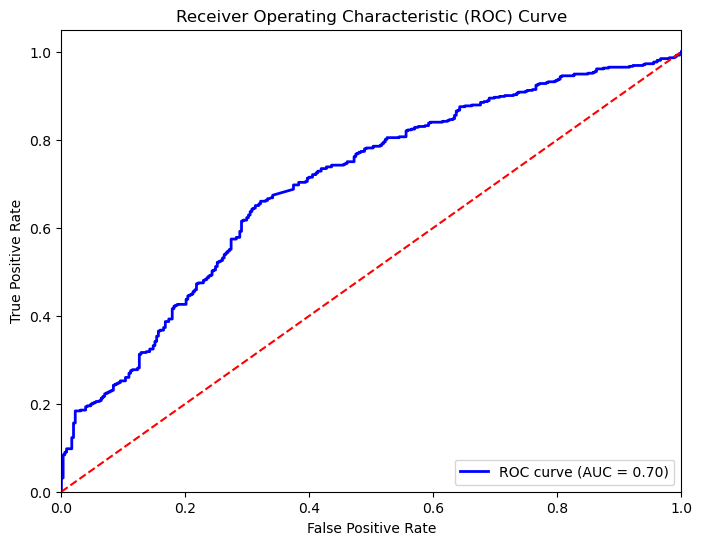

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_output, prediction_df['probability'])

# Compute AUC score
auc = roc_auc_score(test_output, prediction_df['probability'])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


AUC score of 0.70 also proves that the model has a predicting cability to distinguish between drug that are hERG blocker 
and hERG non-blocker.

In [24]:
!pip install umap-learn

Defaulting to user installation because normal site-packages is not writeable


To further explore hERG blocker and hERG Non-blocker on the validata data, I'll be using PCA and UMAP to achieve that

In [23]:
# Calculate Morgan fingerprints
def calculate_morgan_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)  # Morgan fingerprint radius=2, bit length=1024
        return list(fp)
    else:
        return None
#Apply to the input column a nd retun a column named "Morgan Fingerprint"
prediction_df['morgan_fingerprint'] = prediction_df['input'].apply(calculate_morgan_fingerprint)


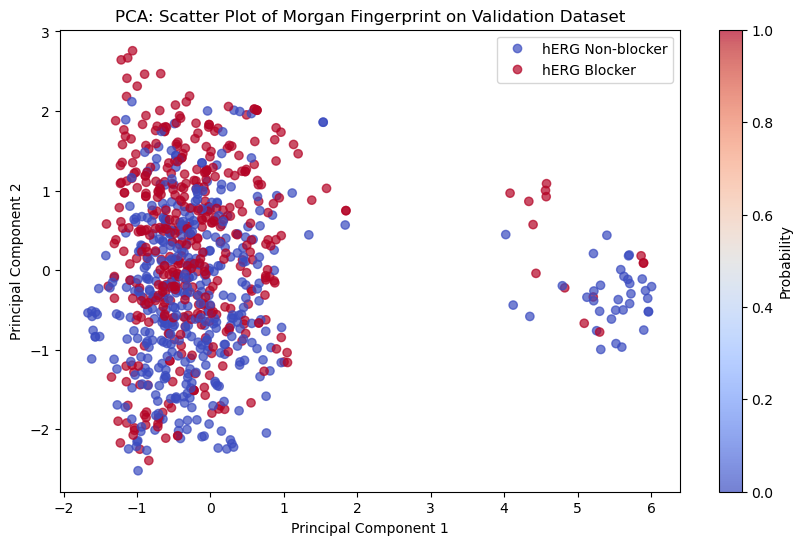

In [40]:
# PCA on Morgan fingerprints
X = prediction_df['morgan_fingerprint'].tolist()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=prediction_df['probability']>=0.5, cmap='coolwarm', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Scatter Plot of Morgan Fingerprint on Validation Dataset')
plt.colorbar(label='Probability')
legend_labels = ['hERG Non-blocker', 'hERG Blocker']
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

# Show the plot
plt.show()


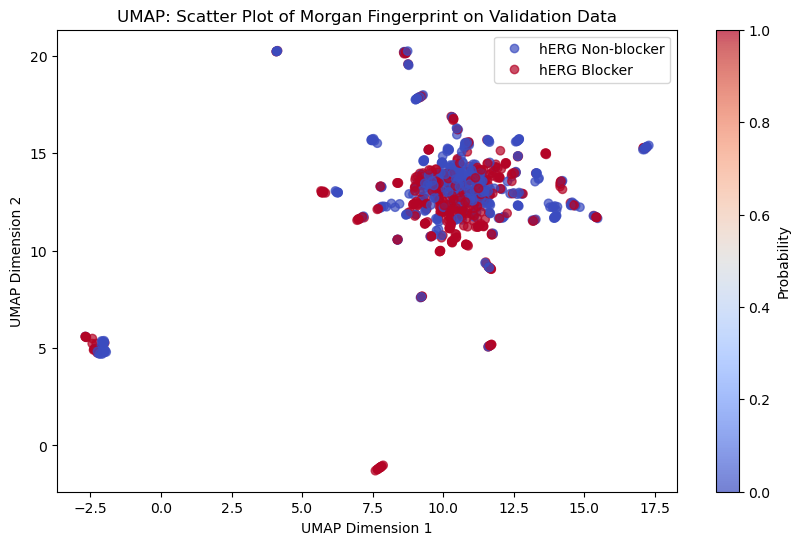

In [44]:
from umap import UMAP

# UMAP for dimensionality reduction
X = prediction_df['morgan_fingerprint'].tolist()
mapper = UMAP(n_components=2)
X_umap = mapper.fit_transform(X)

# Plot the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=prediction_df['probability']>=0.5, cmap='coolwarm', alpha=0.7)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP: Scatter Plot of Morgan Fingerprint on Validation Data')
plt.colorbar(label='Probability')
legend_labels = ['hERG Non-blocker', 'hERG Blocker']

# Separate handles and labels from the Legend object
handles, _ = scatter.legend_elements()
plt.legend(handles, legend_labels)

# Show the plot
plt.show()
